In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import pickle_data

import tf_lab.point_clouds.in_out as pio

from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.nips.data_sets.shape_net import pc_loader as sn_pc_loader
from tf_lab.icml.ae_farm_helper import EMD_Stats, Chamfer_Stats

In [3]:
from bench_pc_gan.evaluate_gan import entropy_of_occupancy_grid, jensen_shannon_divergence
from tf_lab.nips.helper import pclouds_centered_and_half_sphere
from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
from general_tools.simpletons import iterate_in_chunks

PyTorch not working. MMD measurement won't be available


In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
class_name = 'chair'
ae_loss = 'emd'
n_pc_samples = 2048
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'

In [6]:
# Load Raw Point-Clouds of class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
syn_id = shape_net_category_to_synth_id()[class_name]
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )
train_data = PointCloudDataSet(pclouds)

6778 files containing complete point clouds were found.


In [7]:
cmp_in_sphere = True
voxel_resolution = 28
pclouds_ = pclouds_centered_and_half_sphere(pclouds)
_, gt_grid_var = entropy_of_occupancy_grid(pclouds_, voxel_resolution, in_sphere=cmp_in_sphere)

In [8]:
experiment_stats = EMD_Stats
ae_ids = experiment_stats.experiments_ids
exp_type = 'last'
arch_tag = 'mlp_arch'

ae_ids = [6]

for ae_id in ae_ids:
    ae_name = '_'.join(['ae_farm', class_name, arch_tag, str(ae_id), str(n_pc_samples) + 'pts', ae_loss])
    train_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/ae_farming', ae_name)
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    bneck = conf.encoder_args['n_filters'][-1]
    print 'B-neck Size = ', bneck
    
    if exp_type == 'max_min':
        load_epoch = experiment_stats.max_min_epochs[bneck][0]
    elif exp_type == 'best':
        load_epoch = experiment_stats.best_epochs[bneck][0]
    elif exp_type == 'last':
        saved_epochs = read_saved_epochs(conf.train_dir)
        load_epoch = saved_epochs[-1]
    else:
        assert(False)
    
    load_epoch = 990 
    
    reset_tf_graph()
    ae = PointNetAutoEncoder(ae_name, conf)    
    print ae_name
    ae.restore_model(conf.train_dir, load_epoch, verbose=True)
    
    _, latent_codes, _ = latent_embedding_of_entire_dataset(train_data, ae, conf)
    reconstructed = []
    for b in iterate_in_chunks(latent_codes, conf.batch_size):
        reconstructed.append(ae.decode(b))
    reconstructed = np.vstack(reconstructed) 
    reconstructed = pclouds_centered_and_half_sphere(reconstructed)
    _, sample_grid_var = entropy_of_occupancy_grid(reconstructed, voxel_resolution, in_sphere=cmp_in_sphere)
    jsd_epoch = jensen_shannon_divergence(sample_grid_var, gt_grid_var)
    print jsd_epoch

B-neck Size =  4
ae_farm_chair_mlp_arch_6_2048pts_emd
Model restored in epoch 990.
0.00789606509624


In [15]:
## Convolutional Architecture 
# Bneck size - JSD (type of epoch AE 'best', 'last=1Kepochs') 
(4, 0.0030742091352)       0.0030742091352
(8, 0.00135260351788)      0.00130649700971
(16, 0.000822138606231)    0.000892632206115
(32, 0.000644479942822)    0.000688352682992
(64, 0.000647472505707)    0.000638451683484
(128, 0.000561809067982)   0.000580914241943
(256, 0.000567715030499)   0.00067261934256
(512, 0.000554273937081)   0.00057191454412
(1024, 0.000541790000585)  0.000542265466233


# Max_min Epoch
(32, 0.000644479942822)
(64, 0.000733603530406)
(128, 0.000684516282747)
(256, 0.000773909275057)
(512, 0.000771209492351)

In [ ]:
## MLP Architecture ('best')
# Bneck size - best_epoch - EMD loss - JSD
4, 990, 108.468496492, 0.00789606509624
32, 990, 63.9210854623, 0.000950271392651
64, 1000, 62.8441277811, 0.000835849301129
128, 990, 61.8659574217, 0.000790472750225
512, 990, 60.9854559832, 0.000754295261466
1024, 990, 60.2241837284, 0.000722824995107

In [17]:
conv_arch_jsd = {4: 0.0030742091352, 
                 8: 0.00135260351788,
                 16: 0.000822138606231,
                 32: 0.000644479942822,
                 64: 0.000647472505707, 
                 128: 0.000561809067982, 
                 256: 0.000567715030499,
                 512: 0.000554273937081,
                 1024: 0.000541790000585
                }

# Below numbers that have + are fake (my extrapolations.) 
mlp_arch_jsd = {4: 0.00789606509624,
                8: 0.00135260351788 + (0.00135260351788 * 0.35),
                16: 0.000822138606231 + (0.000822138606231 * 0.37),
                32: 0.000950271392651,
                64: 0.000835849301129,
                128: 0.000790472750225,                
                512: 0.000754295261466,
                1024: 0.000722824995107}

In [18]:
mlp_arch_jsd

{4: 0.00789606509624,
 32: 0.000950271392651,
 64: 0.000835849301129,
 128: 0.000790472750225,
 512: 0.000754295261466,
 1024: 0.000722824995107}

In [19]:
from general_tools.simpletons import sort_dict_by_key

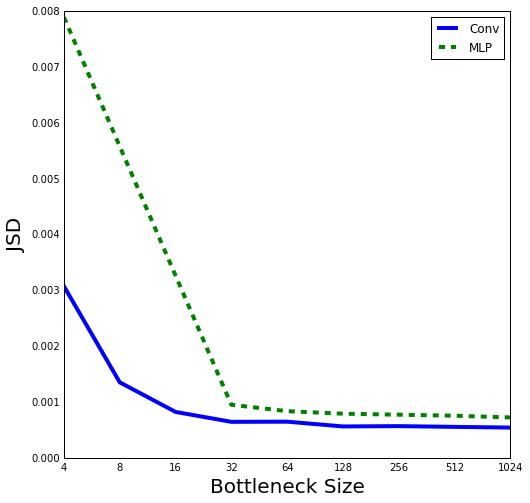

In [20]:
conv_arch_jsd_sorted = sort_dict_by_key(conv_arch_jsd)
n_bnecks = len(conv_arch_jsd)
bnecks = [i[0] for i in conv_arch_jsd_sorted]
jsd_vals = [i[1] for i in conv_arch_jsd_sorted]

plt.figure(figsize=(8, 8))
plt.tight_layout
plt.plot(range(n_bnecks), jsd_vals, linewidth=4.0)
plt.xticks(range(n_bnecks), bnecks, rotation=0);

bnecks = np.array(bnecks)
mlp_pos = []
mlp_vals = []
mlp_perc_diff = []
for bn, jv in sorted(mlp_arch_jsd.iteritems()):
    mlp_pos.append(np.where(bn==bnecks)[0][0])
    mlp_vals.append(jv)
    mlp_perc_diff.append((jv - conv_arch_jsd[bn]) / conv_arch_jsd[bn])
    
plt.plot(mlp_pos, mlp_vals, '--', linewidth=4.0)
plt.legend(['Conv', 'MLP'])
plt.ylabel('JSD', fontsize=20)
plt.xlabel('Bottleneck Size', fontsize=20)
plt.tick_params(axis='x', which='both', bottom='off', top='off')
plt.tick_params(axis='y', which='both', left='off', right='off')

In [21]:
mlp_perc_diff

[1.5684866412727974,
 0.4744778378827795,
 0.2909417678149966,
 0.40701315673731026,
 0.3608708817130787,
 0.3341423694171666]